<a href="https://colab.research.google.com/github/Blaze10/DL/blob/main/ANN/Breadth_vs_depth_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

## Import and organize data

In [13]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

## Construct and sanity check the model

In [14]:
class ANNiris(nn.Module):
  def __init__(self, n_units, n_layers):
    super(ANNiris, self).__init__()

    # create a dictionary to store layers
    self.layers = nn.ModuleDict()
    self.nLayers = n_layers

    ## input layer
    self.layers['input'] = nn.Linear(4, n_units)

    ## Hidden layers
    for i in range(n_layers):
      self.layers[f'hidden{i}'] = nn.Linear(n_units, n_units)

    ## output layers
    self.layers['output'] = nn.Linear(n_units, 3)

  # forward pass
  def forward(self, x):
    x = F.relu(self.layers['input'](x))

    # hidden layers
    for i in range(self.nLayers):
      x = F.relu(self.layers[f'hidden{i}'](x))
    
    x = self.layers['output'](x)
    return x

In [15]:
## generate an instance of the model and inspect it
nUnitsPerLayer = 12
nLayers = 4
net = ANNiris(nUnitsPerLayer, nLayers)
net

ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [16]:
# a quick test of running some numbers through the model
# This simply ensures that the architecture is internally consistent

# 5 samples, 4 dimensions
tmpx = torch.randn(5,4)
# run it through dl
y = net(tmpx)
# exam the shape of output
print(y.shape)
print(' ')
print(y)

torch.Size([5, 3])
 
tensor([[0.0625, 0.0428, 0.0469],
        [0.0641, 0.0365, 0.0460],
        [0.0635, 0.0540, 0.0421],
        [0.0616, 0.0331, 0.0495],
        [0.0635, 0.0423, 0.0468]], grad_fn=<AddmmBackward0>)


## Create a function that trains the model

In [17]:
def train_model(model):
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=.01)

  for epochs in range(num_epochs):
    yHat = model(data)
    loss = lossfun(yHat, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = model(data)
  predlabels = torch.argmax(predictions, axis=1)
  acc = 100 * torch.mean((predlabels == labels).float())

  # total number of trainable parameters in the model
  nParams = sum(p.numel() for p in model.parameters() if p.requires_grad)

  return acc, nParams

In [18]:
num_epochs = 2500
acc = train_model(net)
acc

(tensor(98.), 723)

## Experiment

In [19]:
num_layers = range(1,6)
num_units = np.arange(4,101,3)

accuracies = np.zeros((len(num_units), len(num_layers)))
total_params = np.zeros((len(num_units), len(num_layers)))

num_epochs = 500

for unitidx in range(len(num_units)):
  for layeridx in range(len(num_layers)):
    net = ANNiris(num_units[unitidx], num_layers[layeridx])

    acc, num_params = train_model(net)
    accuracies[unitidx, layeridx] = acc
    total_params[unitidx, layeridx] = num_params

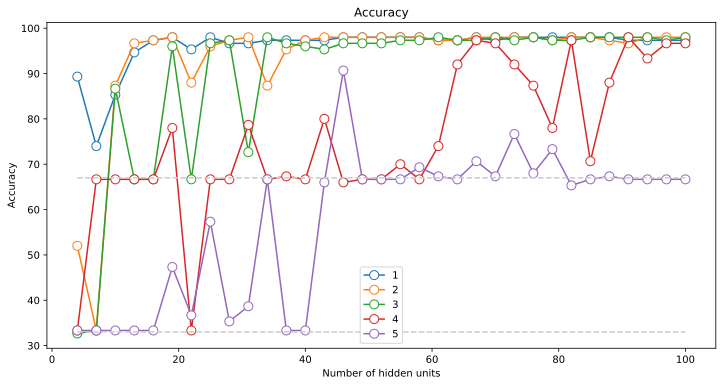

In [20]:
fig, ax = plt.subplots(1,figsize=(12,6))
ax.plot(num_units, accuracies, 'o-', markerfacecolor='w', markersize=9)
ax.plot(num_units[[0, -1]], [33, 33], '--', color=[.8,.8,.8])
ax.plot(num_units[[0, -1]], [67, 67], '--', color=[.8,.8,.8])
ax.legend(num_layers)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()

In [22]:
total_params[:5], accuracies[:5]

(array([[  55.,   75.,   95.,  115.,  135.],
        [ 115.,  171.,  227.,  283.,  339.],
        [ 193.,  303.,  413.,  523.,  633.],
        [ 289.,  471.,  653.,  835., 1017.],
        [ 403.,  675.,  947., 1219., 1491.]]),
 array([[89.33332825, 52.        , 32.66666412, 33.33333588, 33.33333588],
        [74.        , 33.33333588, 33.33333588, 66.66667175, 33.33333588],
        [85.33333588, 87.33333588, 86.66666412, 66.66667175, 33.33333588],
        [94.66666412, 96.66666412, 66.66667175, 66.66667175, 33.33333588],
        [97.33333588, 97.33333588, 66.66667175, 66.66667175, 33.33333588]]))

Text(0.5, 1.0, 'Correlation r=0.081')

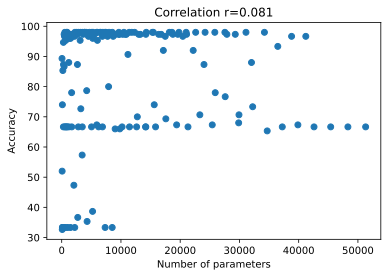

In [23]:
x = total_params.flatten()
y = accuracies.flatten()

r = np.corrcoef(x,y)[0,1]

plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation r='+ str(np.round(r,3)))

  1) Try it again with 1000 training epochs. Do the deeper models eventually learn?

In [24]:
num_layers = range(1,6)
num_units = np.arange(4,101,3)

accuracies = np.zeros((len(num_units), len(num_layers)))
total_params = np.zeros((len(num_units), len(num_layers)))

num_epochs = 1000

for unitidx in range(len(num_units)):
  for layeridx in range(len(num_layers)):
    net = ANNiris(num_units[unitidx], num_layers[layeridx])

    acc, num_params = train_model(net)
    accuracies[unitidx, layeridx] = acc
    total_params[unitidx, layeridx] = num_params

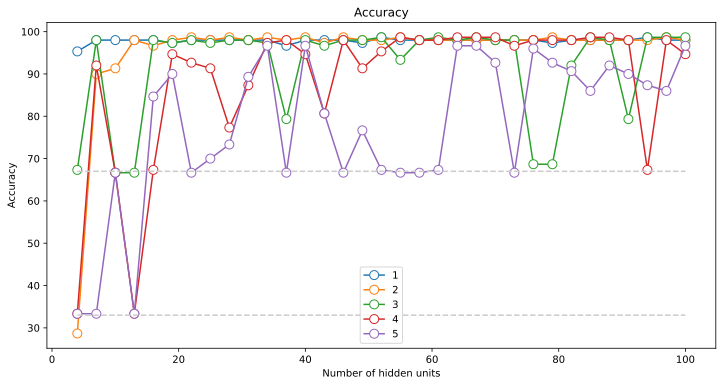

In [25]:
fig, ax = plt.subplots(1,figsize=(12,6))
ax.plot(num_units, accuracies, 'o-', markerfacecolor='w', markersize=9)
ax.plot(num_units[[0, -1]], [33, 33], '--', color=[.8,.8,.8])
ax.plot(num_units[[0, -1]], [67, 67], '--', color=[.8,.8,.8])
ax.legend(num_layers)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()